# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблем, предоставляемым библиотекой CatBoost.

In [1]:
from itertools import product
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import seaborn as sns
iris = sns.load_dataset('iris')

### Задание 1 (3 балла)
Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [2]:
class RandomForestClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", n_estimators=10):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.n_estimators = n_estimators
        self._trees = []
        self.encoder = None
        self.oob = []
        self.oob_j = {}
    def fit(self, X, y):
        X = pd.DataFrame(X)
        y = pd.Series(y)
        y_index = y.index
        self.encoder = preprocessing.LabelEncoder()
        y = pd.Series(self.encoder.fit_transform(y))
        y.index = y_index
        
        for n in range(self.n_estimators):
            tree = DecisionTreeClassifier(criterion=self.criterion, min_samples_leaf=self.min_samples_leaf, 
                                                      max_depth=self.max_depth, max_features=self.max_features)
            X_fit, y_fit = resample(X, y)
            tree.fit(X_fit, y_fit)
            self._trees.append(tree)
            
            oob_index = list(set(X.index) - set(X_fit.index))
            
            self.oob.append(accuracy_score(y[oob_index], tree.predict(X.loc[oob_index])))
            for feature in X.columns:
                X_oob = X.loc[oob_index].copy()
                X_oob[feature] = np.array(resample(X_oob[feature]))
                if feature not in self.oob_j:
                    self.oob_j[feature] = [accuracy_score(y[oob_index], tree.predict(X_oob))]
                else:
                    self.oob_j[feature].append(self.oob[-1] - accuracy_score(y[oob_index], tree.predict(X_oob)))
    def predict(self, X):
        answer = []
        x_ans = np.zeros((len(X), len(self.encoder.classes_)))
        for tree in self._trees:
            x_ans += tree.predict_proba(X)
        return self.encoder.inverse_transform([np.argmax(elem) for elem in x_ans])
    
    @property
    def feature_importance(self):
        tempory = {}
        for key in self.oob_j:
            tempory[key] = sum(self.oob_j[key]) / len(self.oob_j[key])
        return sorted(list(tempory.items()), key=lambda x: x[1], reverse=True)

### Задание 3 (3 балла)
Оптимизируйте по AUC на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации Random Forest: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте ROC кривую (и выведите AUC и accuracy) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [308]:
%%time
X = pd.read_csv('../datasets/cancer.csv')
X, y = X.drop('label', axis=1), X['label']
def GridSearchCV(clf, X, y, params):
    keys = params.keys()
    iters = product(*params.values())
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scores = {}
    for param in iters:
        clf.__init__(**{key : value for key, value in zip(keys, param)})
        clf.fit(X_train, y_train)
        scores[tuple(zip(keys, param))] = roc_auc_score(clf.encoder.transform(y_test), clf.encoder.transform(clf.predict(X_test)))
    return scores
GridSearchCV(RandomForestClassifier(), X, y, {'max_depth' : [2, 3, 5, 7, 10], 'n_estimators' : [5, 10, 20, 30, 50, 100]})

Wall time: 6.31 s


{(('max_depth', 2), ('n_estimators', 5)): 0.9265700483091787,
 (('max_depth', 2), ('n_estimators', 10)): 0.929951690821256,
 (('max_depth', 2), ('n_estimators', 20)): 0.9154589371980676,
 (('max_depth', 2), ('n_estimators', 30)): 0.9265700483091787,
 (('max_depth', 2), ('n_estimators', 50)): 0.9082125603864735,
 (('max_depth', 2), ('n_estimators', 100)): 0.9265700483091787,
 (('max_depth', 3), ('n_estimators', 5)): 0.9193236714975845,
 (('max_depth', 3), ('n_estimators', 10)): 0.9338164251207729,
 (('max_depth', 3), ('n_estimators', 20)): 0.9193236714975845,
 (('max_depth', 3), ('n_estimators', 30)): 0.929951690821256,
 (('max_depth', 3), ('n_estimators', 50)): 0.9265700483091787,
 (('max_depth', 3), ('n_estimators', 100)): 0.9154589371980676,
 (('max_depth', 5), ('n_estimators', 5)): 0.9304347826086957,
 (('max_depth', 5), ('n_estimators', 10)): 0.9371980676328503,
 (('max_depth', 5), ('n_estimators', 20)): 0.9227053140096618,
 (('max_depth', 5), ('n_estimators', 30)): 0.9632850241545

#### Возьму глубину 5, количество деревьев 100

In [3]:
X = pd.read_csv('../datasets/cancer.csv')
X, y = X.drop('label', axis=1), X['label']
clf = RandomForestClassifier(max_depth=5, n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
fpr, tpr, area = roc_curve(clf.encoder.transform(y_test), clf.encoder.transform(clf.predict(X_test)))

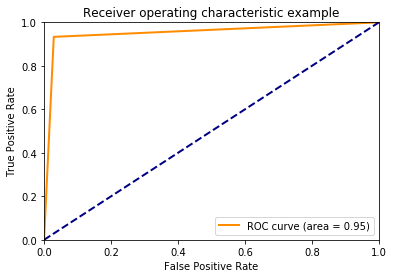

In [4]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(clf.encoder.transform(y_test), clf.encoder.transform(clf.predict(X_test)))) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [5]:
print("Importance:", *clf.feature_importance)

Importance: ('23', 0.0887043998407497) ('28', 0.05906358476708553) ('24', 0.058182213435269095) ('21', 0.05475898841256864) ('14', 0.03405248577409274) ('8', 0.03040990515522382) ('7', 0.029203565400705636) ('1', 0.027559456830735764) ('3', 0.02730757335049633) ('4', 0.026624208032503892) ('27', 0.02310078164791217) ('26', 0.01887832515738594) ('13', 0.016100790767041403) ('22', 0.016036033883161608) ('11', 0.01532454082003197) ('25', 0.01281426121072137) ('29', 0.012238764991181726) ('2', 0.01211537255222986) ('17', 0.011698621699076433) ('18', 0.011551055770657306) ('30', 0.011520610619905735) ('5', 0.011313337321116074) ('6', 0.01044860127202841) ('20', 0.010312222281836446) ('10', 0.010244648546206854) ('16', 0.01001475382855443) ('15', 0.009744584231159058) ('12', 0.009154626991061671) ('9', 0.009020074848030695) ('19', 0.009018142088408676)


In [6]:
X = pd.read_csv('../datasets/spam.csv')
X, y = X.drop('label', axis=1), X['label']
clf = RandomForestClassifier(max_depth=7, n_estimators=200)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
fpr, tpr, area = roc_curve(clf.encoder.transform(y_test), clf.encoder.transform(clf.predict(X_test)))

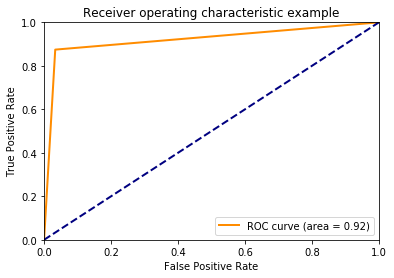

In [7]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(clf.encoder.transform(y_test), clf.encoder.transform(clf.predict(X_test)))) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [8]:
print("Importance:", *clf.feature_importance)

Importance: ('word_freq_remove', 0.04088932691189242) ('char_freq_!', 0.03934743872274725) ('char_freq_$', 0.0360767138711768) ('word_freq_hp', 0.03236289752805078) ('capital_run_length_longest', 0.027408486729215274) ('word_freq_free', 0.027227738298324877) ('capital_run_length_average', 0.023660313498819648) ('word_freq_your', 0.019903619440288664) ('capital_run_length_total', 0.019194230034735183) ('word_freq_george', 0.01844947166257954) ('word_freq_money', 0.016144454983302373) ('word_freq_our', 0.01423278647569683) ('word_freq_hpl', 0.013916958534270671) ('word_freq_000', 0.01351381417093168) ('word_freq_edu', 0.011215896875674309) ('word_freq_1999', 0.009232447233175579) ('word_freq_you', 0.008583710224904983) ('word_freq_receive', 0.008075737422681485) ('word_freq_business', 0.007967734185261845) ('word_freq_internet', 0.007846803597213323) ('word_freq_credit', 0.006858869104035863) ('word_freq_meeting', 0.006811076086567065) ('word_freq_labs', 0.006754200005510583) ('word_freq

### Задание 4 (3 балла)
Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [9]:
def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [12]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)

X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)
print("Accuracy:", np.mean(rfc.predict(X) == y))
print("Importance:", *rfc.feature_importance)

Accuracy: 1.0
Importance: (4, 0.4021915296804534) (3, 0.22554211970155486) (2, 0.21934309485108716) (0, 0.01) (1, 0.01) (5, 0.01)


Проверьте, какие признаки важны для датасетов cancer и spam?

### Задание 5 (1 балл)
В качестве аьтернативы попробуем CatBoost. 

Туториалы можно найти, например, [здесь](https://catboost.ai/docs/) и [здесь](https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb).

Также, как и реализованный ними RandomForest, примените его для наших датасетов.

In [2]:
df = pd.read_csv('../datasets/cancer.csv')
df.label = df.label.apply(lambda x: 0 if x == "M" else 1)
X, y = df.drop('label', axis=1), df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = CatBoostClassifier(silent=True)
clf.fit(X_train, y_train)
print("Accuracy:", np.mean(clf.predict(X) == y))

Accuracy: 0.9947275922671354


In [4]:
cross_validate(clf, X, y, cv=5)

{'fit_time': array([8.63290524, 7.17264819, 6.16133451, 6.26814032, 7.21070743]),
 'score_time': array([0.00604868, 0.00398827, 0.00299239, 0.0068531 , 0.00698209]),
 'test_score': array([0.95652174, 0.95652174, 0.98230088, 0.97345133, 0.96460177])}